In [7]:
from awpy import Demo

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import random
import sys
import os

pd.set_option('display.max_columns', 100)
sys.path.append(os.path.abspath('./package'))

from CS2_tabular_snapshots import CS2_TabularSnapshots

### ***awpy2*** test

In [49]:
player_cols = [
    'X',
    'Y',
    'Z',
    'health',
    'score',
    'mvps',
    'is_alive',
    'balance',
    'inventory',
    'life_state',
    'pitch',
    'yaw',
    'armor',
    'has_defuser',
    'has_helmet',
    'player_name',
    'start_balance',
    'total_cash_spent',
    'cash_spent_this_round',
    'move_collide',
    'move_type',
    'team_num',
    'jump_velo',
    'fall_velo',
    'in_crouch',
    'crouch_state',
    'ducked',
    'ducking',
    'in_duck_jump',
    'spotted',
    'approximate_spotted_by',
    'time_last_injury',
    'player_state',
    'passive_items',
    'is_scoped',
    'is_walking',
    'resume_zoom',
    'is_defusing',
    'in_bomb_zone',
    'is_strafing',
    'move_state',
    'which_bomb_zone',
    'in_hostage_rescue_zone',
    'stamina',
    'direction',
    'armor_value',
    'velo_modifier',
    'flash_duration',
    'flash_max_alpha',
    'round_start_equip_value',
    'current_equip_value',
    'velocity',
    'velocity_X',
    'velocity_Y',
    'velocity_Z',
    'FIRE',
    'USE'
]
other_cols = [
    'num_player_alive_ct',
    'num_player_alive_t',
    'ct_losing_streak',
    't_losing_streak',
    'active_weapon_name',
    'active_weapon_ammo',
    'total_ammo_left',
    'is_in_reload',
    'alive_time_total',
    'is_bomb_dropped'
]

dem = Demo(path='../../data/matches-raw/cs2/2024/_blast-premier-spring-final-2024-faze-vs-vitality-bo3-lQLvdLlJcL7dI4fNDLSZOXfaze-vs-vitality-m1-inferno.dem', \
           player_props=player_cols, other_props=other_cols)

In [35]:
dem.events.keys()

dict_keys(['other_death', 'announce_phase_end', 'vote_cast', 'round_prestart', 'player_spawn', 'cs_pre_restart', 'weapon_reload', 'hltv_fixed', 'round_poststart', 'player_given_c4', 'smokegrenade_detonate', 'round_officially_ended', 'server_cvar', 'player_jump', 'bomb_dropped', 'round_time_warning', 'player_team', 'cs_intermission', 'bomb_planted', 'player_connect_full', 'round_end_upload_stats', 'player_sound', 'player_hurt', 'flashbang_detonate', 'hegrenade_detonate', 'round_announce_match_point', 'cs_win_panel_match', 'weapon_zoom', 'begin_new_match', 'round_freeze_end', 'player_death', 'player_ping', 'inferno_expire', 'item_pickup', 'smokegrenade_expired', 'round_announce_last_round_half', 'bomb_defused', 'entity_killed', 'bomb_pickup', 'player_disconnect', 'hltv_versioninfo', 'item_equip', 'weapon_fire', 'hltv_chase', 'player_footstep', 'cs_round_final_beep', 'round_announce_warmup', 'player_ping_stop', 'inferno_startburn', 'bomb_exploded', 'round_announce_match_start', 'cs_round_

In [46]:
dem.bomb

,tick,event,site,X,Y,Z,round
0,16643,planted,BombsiteA,-253.966553,-2154.450928,-172.904785,1
1,23366,planted,BombsiteA,-494.286255,-2004.636841,-179.968750,2
2,25990,exploded,BombsiteA,-494.286255,-2004.636841,-179.968750,2
3,31485,planted,BombsiteB,-1905.131470,243.703110,-159.968750,3
4,34109,exploded,BombsiteB,-1905.131470,243.703110,-159.968750,3
5,41651,planted,BombsiteA,-257.947632,-2156.418945,-172.906799,4
6,88075,planted,BombsiteA,-624.907166,-2177.932861,-179.968750,11
7,94014,planted,BombsiteA,-607.471863,-2168.360352,-179.968750,12
8,111524,planted,BombsiteB,-1973.737671,450.031372,-159.968750,13
9,118853,planted,BombsiteA,-280.689209,-2158.102783,-173.767883,14


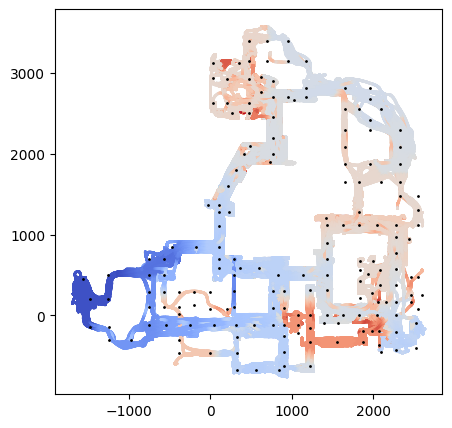

In [55]:
plt.figure(figsize=(5, 5))
plt.scatter(dem.ticks['X'], dem.ticks['Y'], c=dem.ticks['Z'], cmap='coolwarm', s=1)
nodes = pd.read_csv('../../data/inferno_graph/graph_models/manual/nodes_v1_5.csv')
plt.scatter(nodes['x'], nodes['y'], c='black', s=1)

### Graph creator test

In [8]:
tc = CS2_TabularSnapshots()
df, df_dict = tc.process_match(
    match_path='../../data/matches-raw/cs2/2024/_iem-dallas-2024-g2-vs-mouz-bo3-O1BgM30a6fWPjk5gU5VUnXg2-vs-mouz-m2-nuke.dem',
    player_stats_data_path='../../data/player-stats/scraped-in-2024/2022/norm_imputed_player_stats_2022_utf.csv',
    missing_player_stats_data_path='../../data/player-stats/scraped-in-2024/missing_players.csv',
    weapon_data_path='../../data/weapon_info/ammo_info.csv',

    ticks_per_second=4,
    numerical_match_id=1000,
    num_permutations_per_round=1,
    build_dictionary=True
)
df = tc.impute_match(df)
df

,CT0_name,CT0_X,CT0_Y,CT0_Z,CT0_pitch,CT0_yaw,CT0_velocity_X,CT0_velocity_Y,CT0_velocity_Z,CT0_health,CT0_armor_value,CT0_active_weapon_magazine_size,CT0_active_weapon_ammo,CT0_active_weapon_magazine_ammo_left_%,CT0_active_weapon_max_ammo,CT0_total_ammo_left,CT0_active_weapon_total_ammo_left_%,CT0_flash_duration,CT0_balance,CT0_current_equip_value,CT0_round_start_equip_value,CT0_is_alive,CT0_is_CT,CT0_is_shooting,CT0_is_crouching,CT0_is_ducking,CT0_is_duck_jumping,CT0_is_walking,CT0_is_spotted,CT0_is_scoped,CT0_is_defusing,CT0_is_reloading,CT0_is_in_bombsite,CT0_stat_kills,CT0_stat_HS_kills,CT0_stat_opening_kills,CT0_stat_deaths,CT0_stat_opening_deaths,CT0_stat_assists,CT0_stat_flash_assists,CT0_stat_damage,CT0_stat_weapon_damage,CT0_stat_nade_damage,CT0_stat_survives,CT0_stat_KPR,CT0_stat_ADR,CT0_stat_DPR,CT0_stat_HS%,CT0_stat_SPR,CT0_inventory_C4,...,T9_hltv_maps_played,T9_hltv_saved_by_teammatePR,T9_hltv_saved_teammatesPR,T9_hltv_opening_kill_rating,T9_hltv_team_W%_after_opening,T9_hltv_opening_kill_in_W_rounds,T9_hltv_rating_1.0_all_Career,T9_hltv_clutches_1on1_ratio,T9_hltv_clutches_won_1on1,T9_hltv_clutches_won_1on2,T9_hltv_clutches_won_1on3,T9_hltv_clutches_won_1on4,T9_hltv_clutches_won_1on5,numerical_match_id,match_id,tick,round,time,remaining_time,freeze_end,end,CT_wins,CT_alive_num,T_alive_num,CT_total_hp,T_total_hp,CT_equipment_value,T_equipment_value,CT_losing_streak,T_losing_streak,is_bomb_dropped,is_bomb_being_planted,is_bomb_being_defused,is_bomb_defused,is_bomb_planted_at_A_site,is_bomb_planted_at_B_site,bomb_X,bomb_Y,bomb_Z,bomb_mx_pos1,bomb_mx_pos2,bomb_mx_pos3,bomb_mx_pos4,bomb_mx_pos5,bomb_mx_pos6,bomb_mx_pos7,bomb_mx_pos8,bomb_mx_pos9,smokes_active,infernos_active
0,NiKo,2585.000000,-344.000000,-351.96875,-0.973328,-169.127655,0.000000,0.000000,0.0,100,100,0,0.0,0.0,0,1.0,inf,0.0,150,850,200,True,1,False,0,0,0,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.000000,0.000000,0.000000,1.000000,0,...,0.148551,0.500000,0.611111,0.432099,0.776,0.321321,0.666667,1.0,0.371795,0.466667,0.384615,0.4,0.0,1000,../../data/matches-raw/cs2/2024/_iem-dallas-20...,6338,1,115.000000,115.000000,6338,10621,1,5,4600,500,500,4250,4600,1,1,False,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,[],[]
1,NiKo,2561.477295,-348.519653,-351.96875,-0.973328,-169.127655,-2.631592,-0.505859,0.0,100,100,0,0.0,0.0,0,1.0,inf,0.0,150,850,200,True,1,False,0,0,0,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.000000,0.000000,0.000000,1.000000,0,...,0.148551,0.500000,0.611111,0.432099,0.776,0.321321,0.666667,1.0,0.371795,0.466667,0.384615,0.4,0.0,1000,../../data/matches-raw/cs2/2024/_iem-dallas-20...,6352,1,114.781250,114.781250,6338,10621,1,5,4600,500,500,4250,4600,1,1,False,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,[],[]
2,NiKo,2511.274414,-358.160583,-351.96875,-0.973328,-169.127655,0.000000,0.000000,0.0,100,100,0,0.0,0.0,0,1.0,inf,0.0,150,850,200,True,1,False,0,0,0,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.000000,0.000000,0.000000,1.000000,0,...,0.148551,0.500000,0.611111,0.432099,0.776,0.321321,0.666667,1.0,0.371795,0.466667,0.384615,0.4,0.0,1000,../../data/matches-raw/cs2/2024/_iem-dallas-20...,6367,1,114.546875,114.546875,6338,10621,1,5,4600,500,500,4250,4600,1,1,False,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,[],[]
3,NiKo,2461.024414,-351.072693,-351.96875,-0.695221,-171.491425,-3.500244,1.277344,0.0,100,100,0,0.0,0.0,0,1.0,inf,0.0,150,850,200,True,1,False,0,0,0,False,False,False,False,False,False,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.000000,0.000000,0.000000,1.000000,0,...,0.148551,0.500000,0.611111,0.432099,0.776,0.321321,0.666667,1.0,0.371795,0.466667,0.384615,0.4,0.0,1000,../../data/matches-raw/cs2/2024/_iem-dallas-20...,6381,1,114.328125,114.328125,6338,10621,1,5,4600,500,500,4250,4600,1,1,False,0,0,0,0,0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,[],[]
4,NiKo,2406.570068,-322.067566,-351.96875,-0.677719,-171.282684,-3.386230,1.816956,0.0,100,100,0,0.0,0.0,0,1.0,inf,0.0,150,850,200,True,1,False

In [10]:
df = tc.impute_match(df, method='zero')

In [ ]:
df = tc.noramlize_match(df)

In [4]:
df_dict

,column,min,max
0,CT0_X,-500.937134,2585.0
1,CT0_Y,-2426.955322,709.009216
2,CT0_Z,-775.96875,-73.702698
3,CT0_pitch,-75.849266,88.999908
4,CT0_yaw,-179.861984,179.96637
...,...,...,...
1549,bomb_mx_pos5,0,0
1550,bomb_mx_pos6,0,0
1551,bomb_mx_pos7,0,1
1552,bomb_mx_pos8,0,1
